In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import ollama  # Ollama (Phi-4) 연결

c:\Users\korea\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

# 전체 그래프에 적용할 폰트 설정
plt.rcParams["font.family"] = font_name

# 음수 기호(-)가 깨지지 않도록 설정
plt.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    message=".*Could not find the number of physical cores.*"
)


In [3]:
# CUDA 사용 가능 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ---------------------------
# 1. Train 데이터 로드 및 전처리
# ---------------------------
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("LB_0.5464_mean_vector_submission.csv", encoding="utf-8-sig")

# 데이터프레임 기본 구조 확인
print("DataFrame Info:")
train_df.info()

print("\nDataFrame Head:")
print(train_df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               23422 non-null  object
 1   발생일시             23422 non-null  object
 2   사고인지 시간          23422 non-null  object
 3   날씨               23422 non-null  object
 4   기온               23422 non-null  object
 5   습도               23422 non-null  object
 6   공사종류             23422 non-null  object
 7   연면적              23422 non-null  object
 8   층 정보             23422 non-null  object
 9   인적사고             23390 non-null  object
 10  물적사고             21932 non-null  object
 11  공종               23411 non-null  object
 12  사고객체             22735 non-null  object
 13  작업프로세스           23359 non-null  object
 14  장소               23422 non-null  object
 15  부위               23422 non-null  object
 16  사고원인             23359 non-null  object
 17  재발방지대책 및 향후조치계획


결측치 개수:
ID                    0
발생일시                  0
사고인지 시간               0
날씨                    0
기온                    0
습도                    0
공사종류                  0
연면적                   0
층 정보                  0
인적사고                 32
물적사고               1490
공종                   11
사고객체                687
작업프로세스               63
장소                    0
부위                    0
사고원인                 63
재발방지대책 및 향후조치계획       0
dtype: int64
ID         0
발생일시       0
사고인지 시간    0
날씨         0
기온         0
습도         0
공사종류       0
연면적        0
층 정보       0
인적사고       0
물적사고       0
공종         0
사고객체       1
작업프로세스     0
장소         0
부위         0
사고원인       0
dtype: int64
텍스트 길이 평균: 60.18768679019725
텍스트 길이 분산: 1229.2076738342105
텍스트 길이 중앙값 51.0


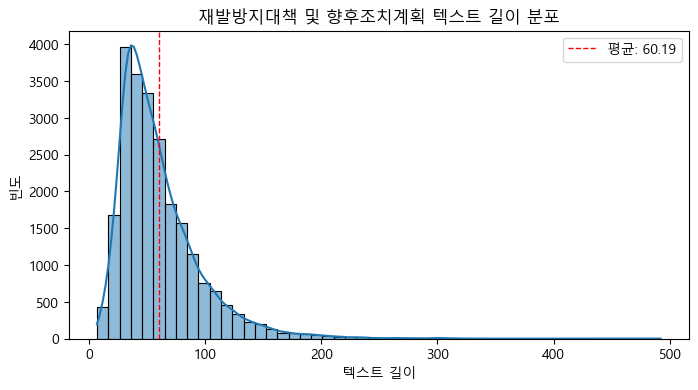

In [6]:
# 결측치 확인
print("\n결측치 개수:")
print(train_df.isnull().sum())
print(test_df.isnull().sum())

# 결측치 처리 (예시: 빈 문자열로 채우기)
train_df = train_df.fillna("")
test_df = test_df.fillna("")

# 타깃 컬럼(재발방지대책 및 향후조치계획)의 길이 계산
train_df["plan_length"] = train_df["재발방지대책 및 향후조치계획"].apply(len)

# 텍스트 길이의 평균과 분산 계산
mean_length = train_df["plan_length"].mean()
variance_length = train_df["plan_length"].var()
median_length = train_df["plan_length"].median()

print("텍스트 길이 평균:", mean_length)
print("텍스트 길이 분산:", variance_length)
print("텍스트 길이 중앙값", median_length)
# 텍스트 길이 분포 시각화
plt.figure(figsize=(8, 4))
sns.histplot(train_df["plan_length"], bins=50, kde=True)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'평균: {mean_length:.2f}')
plt.title("재발방지대책 및 향후조치계획 텍스트 길이 분포")
plt.xlabel("텍스트 길이")
plt.ylabel("빈도")
plt.legend()
plt.show()

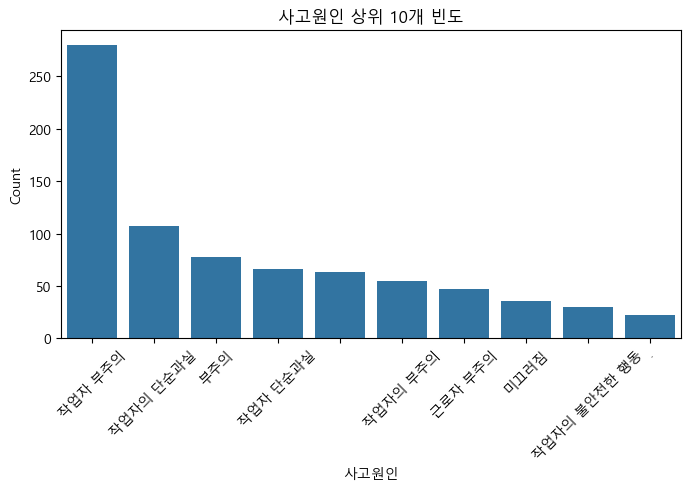

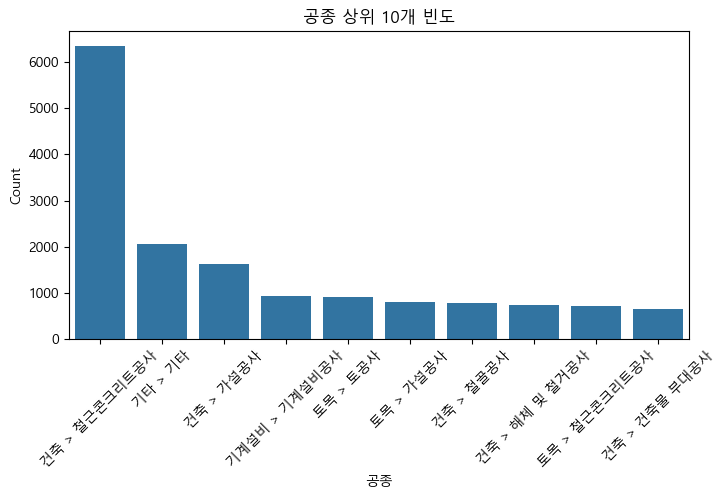

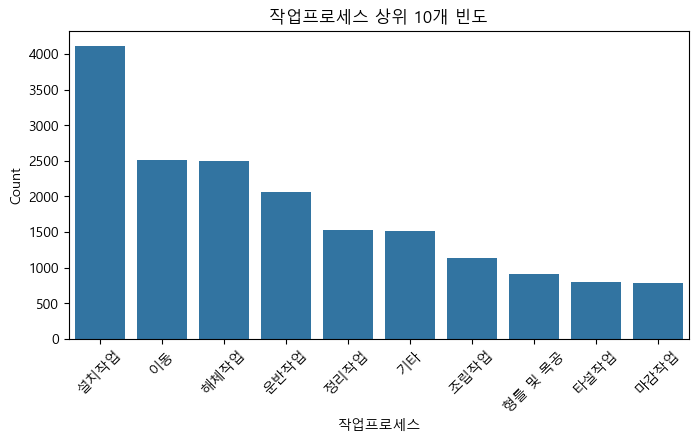

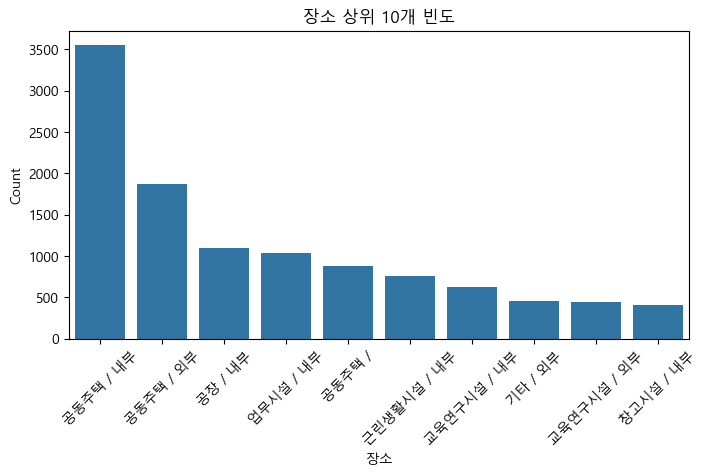

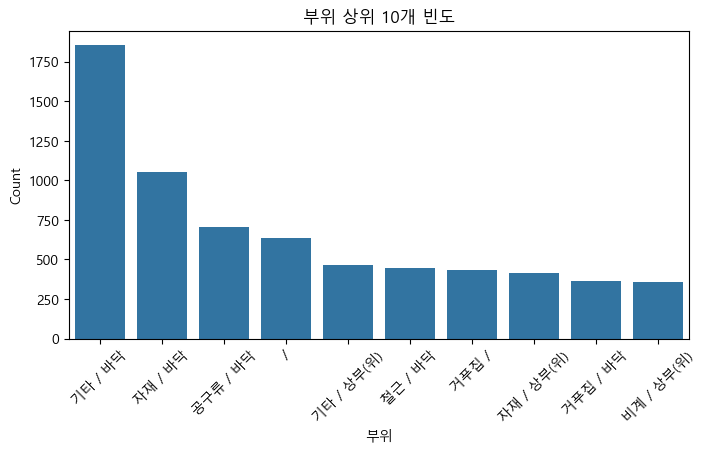

In [7]:
# 예: 사고원인, 공종, 작업프로세스, 장소, 부위 등 범주형 칼럼의 값 분포
categorical_cols = ["사고원인", "공종", "작업프로세스", "장소", "부위"]

for col in categorical_cols:
    value_counts = train_df[col].value_counts().head(10)  # 상위 10개만 예시
    plt.figure(figsize=(8, 4))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f"{col} 상위 10개 빈도")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()


In [8]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

device = "cuda" if torch.cuda.is_available() else "cpu"
# SentenceTransformer 모델 로드 (빠른 임베딩을 위해 'all-MiniLM-L6-v2' 사용)
model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

# 필수 컬럼 확인
columns_needed = ["사고원인", "재발방지대책 및 향후조치계획"]
if not all(col in train_df.columns for col in columns_needed):
    raise ValueError(f"필수 컬럼 {columns_needed}이 데이터에 없습니다.")


In [9]:
# 학습 데이터: 사고객체와 사고원인 각각 벡터화
accident_object_vectors = model.encode(train_df["사고객체"].tolist(), convert_to_numpy=True)
accident_cause_vectors  = model.encode(train_df["사고원인"].tolist(), convert_to_numpy=True)

# 테스트 데이터: 사고객체와 사고원인 각각 벡터화
test_object_vectors = model.encode(test_df["사고객체"].tolist(), convert_to_numpy=True)
test_cause_vectors  = model.encode(test_df["사고원인"].tolist(), convert_to_numpy=True)

In [10]:
# 사용자 지정 가중치 (사용자가 변경 가능)
object_weight = 0.25  # 사고객체 가중치
cause_weight = 0.75  # 사고원인 가중치

# 유사도 행렬 계산
object_similarity_matrix = cosine_similarity(accident_object_vectors)  # 사고객체 유사도
cause_similarity_matrix = cosine_similarity(accident_cause_vectors)  # 사고원인 유사도

# 사용자 가중치를 반영한 최종 유사도 행렬
final_similarity_matrix = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)


# 유사한 사고 찾기 함수 (가중치 반영된 유사도 기준)
def find_similar_accidents(index, top_n=5):
    """
    주어진 사고의 인덱스를 기반으로 가장 유사한 사고를 찾음.
    동일 사고는 제외하고 top_n개를 반환.
    """
    similarities = final_similarity_matrix[index]
    similar_indices = np.argsort(-similarities)[1:top_n+1]  # 자기 자신 제외, 상위 N개 선택
    return similar_indices, similarities[similar_indices]

# 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스
similar_indices, similarity_scores = find_similar_accidents(example_index)

# 결과 출력
print(f"\n🔹 기준 사고객체: {train_df['사고객체'].iloc[example_index]}")
print(f"🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🏷 사고객체: {train_df['사고객체'].iloc[idx]}")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")



🔹 기준 사고객체: 건설자재 > 철근
🔹 기준 사고원인: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.9091)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업시 추락에 대한 대비 미흡 (안전고리 미체결)
  ⮩ 대응 대책: 고소작업 시 안전작업방법 교육, 안전벨트 착용 및 체결 교육, 작업구간 관리감독자 상주, 관리감독자 교육 실시, 안전고리 체결 및 사고 발생 시 보고 철저를 통한 재발 방지 대책.

🔸 2번째 유사한 사고 (유사도: 0.7944)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업 시, 개인보호구 착용을 철저히 하고 상부에 안전대 부착시설에 안전고리 체결 후 작업을 실시하여야 하나 근로자가 이에 대해 부주의하여 발생한 사건임.
  ⮩ 대응 대책: 불안전한 행동 금지와 해당 공종 작업자 특별 교육 실시, 관리감독자의 현장 상주 및 작업 감독, 고소작업 특별 교육 실시 요청과 관리감독자 상주 요청.

🔸 3번째 유사한 사고 (유사도: 0.7711)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 기둥과 안전난간 사이 협소한 공간에서 고소작업대를 벗어나 작업중 고소작업대에서 떨어짐
  ⮩ 대응 대책: 일일 위험 예지 활동 강화에 대한 작업 내용 및 방법, 안전대 착용에 대한 방안.

🔸 4번째 유사한 사고 (유사도: 0.7629)
  🏷 사고객체: 건설자재 > 자재
  🛑 사고원인: 추락위험이 있는 장소에서 안전난간대 해체 후 안전대 미착용 및 안전고리 미체결로 떨어짐
  ⮩ 대응 대책: 추락 위험 발생 구간에 대한 안전대 및 안전고리 체결 교육, 안전난간대 해체 시 원청사 또는 안전관리자 사전 통보 후 작업 진행, 지하 4층 자재 및 장비 반입 시 원청사 또는 안전관리자 통보, 작업 전 안전교육 강화.

🔸 5번째 유사한 사고 (유사도: 0.730

In [11]:
# --- 3. 사용자 지정 가중치 및 최종 유사도 계산 (학습 데이터 간은 기존 코드 참고) ---
# (학습 데이터에서의 최종 유사도 행렬: 향후 참고용)
object_weight = 0.25  # 사고객체 가중치
cause_weight  = 0.75  # 사고원인 가중치

object_similarity_matrix = cosine_similarity(accident_object_vectors)  # (train vs train)
cause_similarity_matrix  = cosine_similarity(accident_cause_vectors)    # (train vs train)
final_similarity_matrix    = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)

# --- 4. 테스트 데이터와 학습 데이터 간의 유사도 계산 ---
# 각 테스트 샘플에 대해, 학습 데이터와의 유사도를 계산
object_similarity_test = cosine_similarity(test_object_vectors, accident_object_vectors)
cause_similarity_test  = cosine_similarity(test_cause_vectors, accident_cause_vectors)
final_similarity_test  = (object_weight * object_similarity_test) + (cause_weight * cause_similarity_test)

def find_similar_accidents_for_test(test_index, top_n=5):
    """
    주어진 테스트 샘플(test_index)의 사고객체 및 사고원인에 대해,
    학습 데이터(train_df)에서 가장 유사한 사례 top_n개를 반환합니다.
    """
    similarities = final_similarity_test[test_index]
    # 내림차순 정렬하여 상위 top_n 사례 추출
    similar_indices = np.argsort(-similarities)[:top_n]
    return similar_indices, similarities[similar_indices]

In [12]:
from langdetect import detect

def is_chinese(text):
    try:
        return detect(text) == "zh-cn"  # 중국어 감지
    except:
        return False  # 감지 실패 시 안전하게 처리
    
def generate_rag_response(top_k_cases, 기준_사고객체, 기준_사고원인):
    system_message = (
        "<|im_start|>system\n"
        "당신은 한국인 건설 사고 전문가입니다.\n"
        "아래 사례들을 참고하여, 안전교육 강화 및 위험요소 점검을 통한 재발방지대책과 향후 조치 계획을 작성해야 합니다.\n"
        "주어진 유사 사고 사례들은 사고객체와 사고원인에 따른 대응 대책이 제시되어 있으므로, 이를 종합해 기준 사고에 맞는 최적의 대응 대책을 도출하세요.\n"
        "한국어로 대답하여야 합니다.\n"
        "<|im_end|>"
    )

    user_message = (
        "<|im_start|>user\n"
        "[기준 사고]\n"
        f"- 사고객체: {기준_사고객체}\n"
        f"- 사고원인: {기준_사고원인}\n\n"
        "[유사 사례 - 기존 대응 대책들]:\n" +
        "\n".join([
            f"{i+1}. 사고객체: {case[0]}, 사고원인: {case[1]}, 대응 대책: {case[2]}"
            for i, case in enumerate(top_k_cases)
        ]) + "\n\n"
        "위의 유사 사례들을 참고하여, 기준 사고에 대한 최적의 재발방지대책 및 향후 조치 계획을 한 문장으로 작성하되, "
        "반드시 \"대응대책:\"으로 시작하는 한 문장으로 답변하세요.\n"
        "<|im_end|>"
    )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    while True:
        response = ollama.chat(model="qwq", messages=messages)
        output = response["message"]["content"]
        
        if not is_chinese(output):  # 중국어가 없으면 반환
            return output
        
        print("❌ 중국어 감지됨. 다시 요청 중...")


In [13]:
def process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results.csv"):
    """
    test_df의 각 샘플에 대해, 학습 데이터와의 최종 유사도를 기반으로 상위 유사 사례(top_n)를 추출한 후,
    generate_rag_response 함수를 호출하여 LLM(QWQ32B) 결과(최적의 재발방지대책 및 향후 조치 계획)를 생성합니다.
    결과는 콘솔에 출력하고, CSV 파일로 저장합니다.
    """
    results = []  # LLM 결과 저장 리스트

    # test_df의 각 샘플에 대해 처리
    for test_idx in tqdm(range(len(test_df)), desc="Processing test cases with LLM"):
        # 학습 데이터와의 최종 유사도에서 상위 top_n 사례 추출 (내림차순 정렬)
        similarities = final_similarity_test[test_idx]
        similar_indices = np.argsort(-similarities)[:top_n]
        
        # 상위 유사 사례에 대한 (사고객체, 사고원인, 대응 대책) 튜플 리스트 생성
        top_k_cases = [
            (
                train_df.iloc[i]["사고객체"],
                train_df.iloc[i]["사고원인"],
                train_df.iloc[i]["재발방지대책 및 향후조치계획"]
            )
            for i in similar_indices
        ]
        
        기준_사고객체 = test_df.iloc[test_idx]["사고객체"]
        기준_사고원인   = test_df.iloc[test_idx]["사고원인"]
        
        # LLM 프롬프트에 따라 최적 대응 대책 생성
        rag_result = generate_rag_response(top_k_cases, 기준_사고객체, 기준_사고원인)
        results.append(rag_result)
        
        # # 콘솔 출력 (각 테스트 샘플 별 상세 정보)
        # print(f"--- Test Sample {test_idx} ---")
        # print(f"테스트 사고객체: {기준_사고객체}")
        # print(f"테스트 사고원인: {기준_사고원인}")
        # print("유사 학습 사례:")
        # for rank, i in enumerate(similar_indices, start=1):
        #     print(f"  {rank}. 사고객체: {train_df.iloc[i]['사고객체']}")
        #     print(f"     사고원인: {train_df.iloc[i]['사고원인']}")
        #     print(f"     대응 대책: {train_df.iloc[i]['재발방지대책 및 향후조치계획']}")
        #     print(f"     유사도: {similarities[i]:.4f}")
        # print("=== LLM 최종 결과 ===")
        # print(rag_result)
        # print("\n" + "-"*80 + "\n")
    
    # test_df에 LLM 결과를 추가하고 CSV 파일로 저장
    results_df = test_df.copy()
    results_df["LLM_결과"] = results
    results_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"LLM 결과가 '{output_csv}' 파일에 저장되었습니다.")
    
    return results_df

In [14]:
results_df = process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results.csv")

Processing test cases with LLM: 100%|██████████| 964/964 [17:00:18<00:00, 63.50s/it]   

LLM 결과가 'llm_results.csv' 파일에 저장되었습니다.


In [15]:
import re
# Step 0: 원본 데이터 길이 확인
print("Initial length of results_df:", len(results_df))

# 기본 답변 (threshold 미만의 경우 사용된 값)
default_answer = "작업전 안전교육 강화 및 작업장 위험요소 점검을 통한 재발 방지와 안전관리 교육 철저를 통한 향후 조치 계획."

def clean_response(text):
    """
    LLM으로 생성된 응답 텍스트에서 <think></think> 태그 내부 내용을 제거하고,
    '대응대책:' 이후의 문장만 추출합니다.
    그리고 문장 끝이 "한다." 또는 "입니다."로 끝나면 단순 마침표 '.'로 변경합니다.
    """
    # <think>...</think> 태그와 그 내부 내용 제거 (DOTALL 플래그 사용)
    cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
    # '대응대책:' 이후의 문장을 추출 (존재하면)
    if "대응대책:" in cleaned:
        cleaned = cleaned.split("대응대책:")[-1].strip()
    # 문장 끝에 "한다." 또는 "입니다."가 있으면 '.'로 치환
    cleaned = re.sub(r'(한다|입니다)\.\s*$', '.', cleaned)
    return cleaned

# Step 1: LLM 응답 결과 정제 (default_answer가 아닌 항목에 대해)
cleaned_test_results = []
for res in results_df["LLM_결과"]:
    if res != default_answer and "대응대책:" in res:
        cleaned_test_results.append(clean_response(res))
    else:
        cleaned_test_results.append(res)

print("Length of cleaned_test_results:", len(cleaned_test_results))

# ---------------------------------------------------
# Step 7: 결과 벡터화 (제출을 위해 `jhgan/ko-sbert-sts` 사용)
# ---------------------------------------------------
# device 설정 (GPU 사용 시 "cuda", 없으면 "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
submission_embedding_model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

pred_embeddings = []
for i in tqdm(range(0, len(cleaned_test_results), 64), desc="Encoding Submission Results"):
    batch = cleaned_test_results[i : i + 64]
    batch_vectors = submission_embedding_model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
    pred_embeddings.extend(batch_vectors)

print("Length of pred_embeddings:", len(pred_embeddings))

# ---------------------------------------------------
# Step 8: 최종 제출 파일 생성
# ---------------------------------------------------
# test_df에 "ID" 컬럼이 존재한다고 가정 (없으면 해당 컬럼명을 수정)
submission = test_df[["ID"]].copy()
print("Length of submission (before adding responses):", len(submission))
print("Length of cleaned_test_results (should match submission length):", len(cleaned_test_results))

submission["재발방지대책 및 향후조치계획"] = cleaned_test_results

# 예측 벡터를 데이터프레임으로 변환 (각 열은 임베딩 차원)
submission_embedding_df = pd.DataFrame(pred_embeddings)
print("Shape of submission_embedding_df:", submission_embedding_df.shape)

# 두 데이터프레임 병합 (ID, 대응 대책, 벡터 컬럼)
submission = pd.concat([submission, submission_embedding_df], axis=1)
print("Final submission shape:", submission.shape)

# cleaned_test_results 리스트 내 NaN 체크
nan_indices = [i for i, x in enumerate(cleaned_test_results) if pd.isna(x)]
if nan_indices:
    print("cleaned_test_results에서 NaN이 발견된 인덱스:", nan_indices)
else:
    print("cleaned_test_results에 NaN이 없습니다.")

# submission DataFrame 내 NaN 체크
if submission.isnull().values.any():
    print("submission DataFrame에 NaN 값이 있습니다:")
    print(submission.isnull().sum())
else:
    print("submission DataFrame에 NaN 값이 없습니다.")

# ---------------------------------------------------
# Step 9: 결과 저장
# ---------------------------------------------------
submission_path = "QWQ_object_rag_submission.csv"
print("Preview of submission DataFrame:")
print(submission.head())
submission.to_csv(submission_path, index=False, encoding="utf-8-sig")

Initial length of results_df: 964
Length of cleaned_test_results: 964


Encoding Submission Results: 100%|██████████| 16/16 [00:01<00:00, 11.02it/s]


Length of pred_embeddings: 964
Length of submission (before adding responses): 964
Length of cleaned_test_results (should match submission length): 964
Shape of submission_embedding_df: (964, 768)
Final submission shape: (964, 770)
cleaned_test_results에 NaN이 없습니다.
submission DataFrame에 NaN 값이 없습니다.
Preview of submission DataFrame:
         ID                                    재발방지대책 및 향후조치계획         0  \
0  TEST_000  지반 침하 예방을 위해 아웃트리거 설치 전 고밀도 지반이나 강화 받침구조물 사용 의... -0.599011   
1  TEST_001  작업자의 숫돌 측면 사용 방지를 위한 특별안전교육 실시와 안전면(보호면판) 의무착용... -0.141440   
2  TEST_002  안전교육 강화와 계단 통행로의 정기적 점검을 통해 미끄러움 및 장애물 제거, 보행주... -0.330941   
3  TEST_003  작업 발판 위 벽돌 잔재 즉시 제거 및 주기적 안전교육 강화, 현장 관리감독 철저로...  0.349080   
4  TEST_004  작업자의 점심식사 이동 경로에 대한 위험요소(미끄럼 가능성, 장애물 등)를 철저히 ... -0.182198   

          1         2         3         4         5         6         7  ...  \
0 -0.873850 -0.044570  0.950516 -0.637628  0.296617  0.593313 -0.592422  ...   
1  0.078324 -0.709843  0.615284 -0.359336  0.31102

In [16]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
'QWQ_object_rag_submission.csv', 
'your_dacon_api_key', 
'236455', 
'mutoy', 
'QWQ32B_clean' )

{'isSubmitted': True, 'detail': 'Success'}
